In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [100]:
def split_dataframe_to_windows(df, window_length, p1, p2):
    windows = []
    start = 0
    end = 0
    windows_label = []
    window_times = []
    while end < len(df) - 1:
        end = start
        while end < len(df) and df.iloc[end]['time'] - df.iloc[start]['time'] < window_length:
            end += 1
        window = df.iloc[start:end]
        if end != len(df) or df.iloc[end-1]['time'] - df.iloc[start]['time'] >= window_length:
            windows.append(window)
            window_times.append([df.iloc[start]['time'], df.iloc[end-1]['time']])
            if df.iloc[start]['time'] < float(p1):
                windows_label.append(0)
            elif df.iloc[end]['time'] > float(p2):
                windows_label.append(0)
            else:
                windows_label.append(1)
        start = end

    return windows, windows_label, window_times

In [101]:
def calculate_rise_fall_times(windows):
    rise_times_list = []
    fall_times_list = []
    for window in windows:
        rise_times = {'r_x': 0, 'r_y': 0, 'r_z': 0, 'r_mag': 0}
        fall_times = {'f_x': 0, 'f_y': 0, 'f_z': 0, 'f_mag': 0}
        for column in ['x', 'y', 'z', 'mag']:
            for i in range(1, len(window)):
                if window.iloc[i][column] > window.iloc[i-1][column]:
                    rise_times["r_"+column] += abs(window.iloc[i]['time'] - window.iloc[i-1]['time'])
                elif window.iloc[i][column] < window.iloc[i-1][column]:
                    fall_times["f_"+column] += abs(window.iloc[i]['time'] - window.iloc[i-1]['time'])
        rise_times_list.append(rise_times)
        fall_times_list.append(fall_times)

    return rise_times_list, fall_times_list

In [102]:
def calculate_rise_fall_times_optimized(windows):
    rise_times_list = []
    fall_times_list = []
    time_step = 0.01
    for window in windows:
        rise_times = {'r_x': 0, 'r_y': 0, 'r_z': 0, 'r_mag': 0}
        fall_times = {'f_x': 0, 'f_y': 0, 'f_z': 0, 'f_mag': 0}

        for i in range(1, len(window)):
            prev_row = window.iloc[i - 1]
            curr_row = window.iloc[i]

            for column in ['x', 'y', 'z', 'mag']:
                if curr_row[column] > prev_row[column]:
                    rise_times["r_"+column] += time_step
                elif curr_row[column] < prev_row[column]:
                    fall_times["f_"+column] += time_step
        rise_times_list.append(rise_times)
        fall_times_list.append(fall_times)

    return rise_times_list, fall_times_list


In [103]:
def duration_above_below_ma(windows):
    above_times_list = []
    below_times_list = []
    time_step = 0.01
    ma_window = 5
    for window in windows:
        above_times = {'a_x': 0, 'a_y': 0, 'a_z': 0, 'a_mag': 0}
        below_times = {'b_x': 0, 'b_y': 0, 'b_z': 0, 'b_mag': 0}

        for column in ['x', 'y', 'z', 'mag']:
            ma = window[column].rolling(window=ma_window).mean()
            for i in range(ma_window, len(window)):
                if window.iloc[i][column] > ma.iloc[i]:
                    above_times["a_"+column] += time_step
                elif window.iloc[i][column] < ma.iloc[i]:
                    below_times["b_"+column] += time_step
        above_times_list.append(above_times)
        below_times_list.append(below_times)

    return above_times_list, below_times_list

In [104]:
import numpy as np
def calculate_rise_fall_times_optimized_v3(windows):

    time_step = 0.01
    rise_times_list = []
    fall_times_list = []
    time_step = 0.01
    for window in windows:
        window_np = window.to_numpy()
        derivatives = np.diff(window_np, axis=0)
        rise_times = {'r_x': 0, 'r_y': 0, 'r_z': 0, 'r_mag': 0}
        fall_times = {'f_x': 0, 'f_y': 0, 'f_z': 0, 'f_mag': 0}
        for i in range(derivatives.shape[0]):
            for idx, column in enumerate(['x', 'y', 'z', 'mag']):
                if derivatives[i, idx] > 0:
                    rise_times["r_"+column] += time_step
                elif derivatives[i, idx] < 0:
                    fall_times["f_"+column] += time_step
        rise_times_list.append(rise_times)
        fall_times_list.append(fall_times)

    return rise_times_list, fall_times_list


In [105]:
foldername = "third-run"
filename = "InterpolationAccelerometerKubaUpstairs2Apple.csv"
filename = "InterpolationAccelerometerKubaDownstairsApple.csv"

In [106]:
test = pd.read_csv(os.path.join(foldername, filename))
activity = test['activity'].unique()[0]
test = test[['time','x','y','z','mag']]
test['time'] = (test['time'] - test['time'].iloc[0])/1000000000
print(activity)
test.head()

downstairs


,time,x,y,z,mag
0,0.00,-0.958817,-0.265930,0.225555,1.020256
1,0.01,-0.923870,-0.267645,0.242044,0.991844
2,0.02,-0.894550,-0.285142,0.254311,0.972728
3,0.03,-0.861678,-0.293123,0.264279,0.947763
4,0.04,-0.852064,-0.303271,0.269903,0.943840


<AxesSubplot:xlabel='time'>

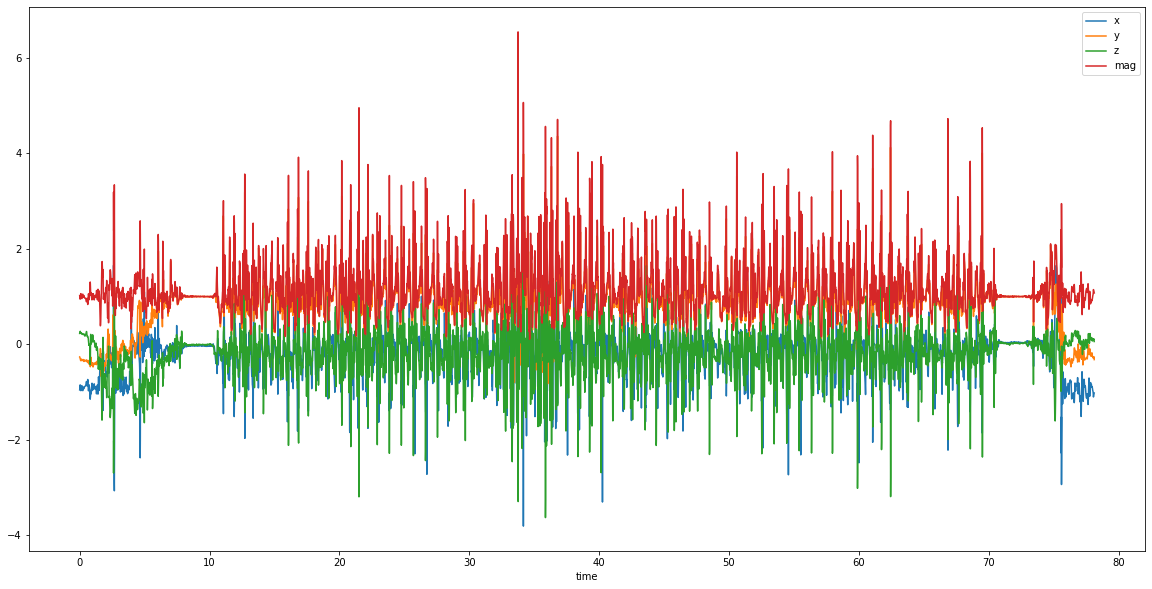

In [107]:
test.plot(x='time', figsize=(20, 10))

<AxesSubplot:xlabel='time'>

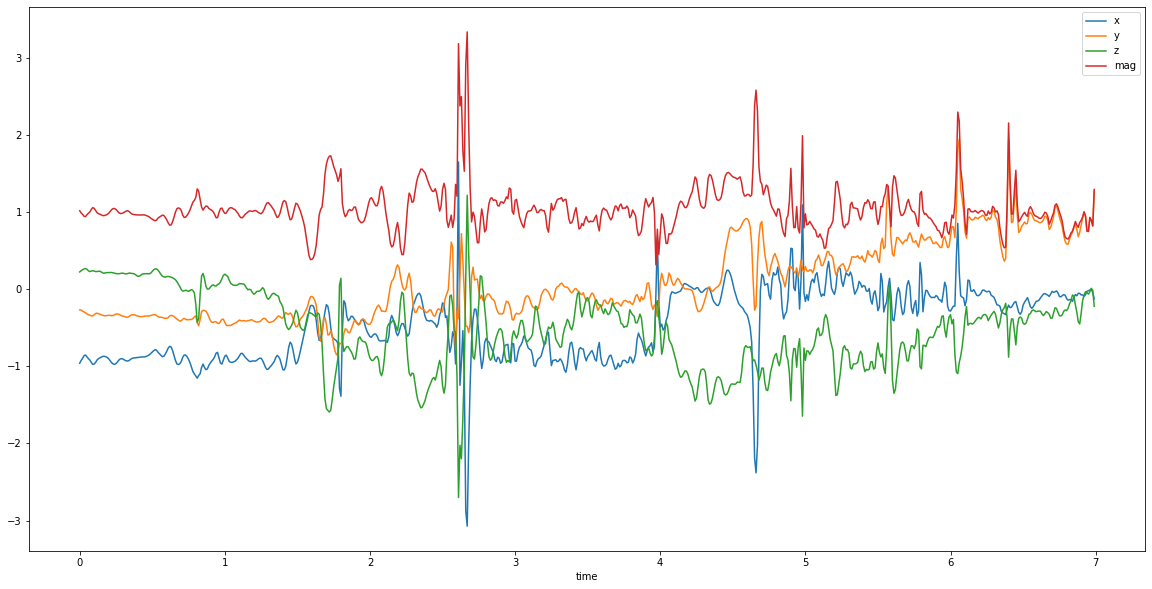

In [108]:
test.where(test["time"]<7).plot(x='time', figsize=(20, 10))

<AxesSubplot:xlabel='time'>

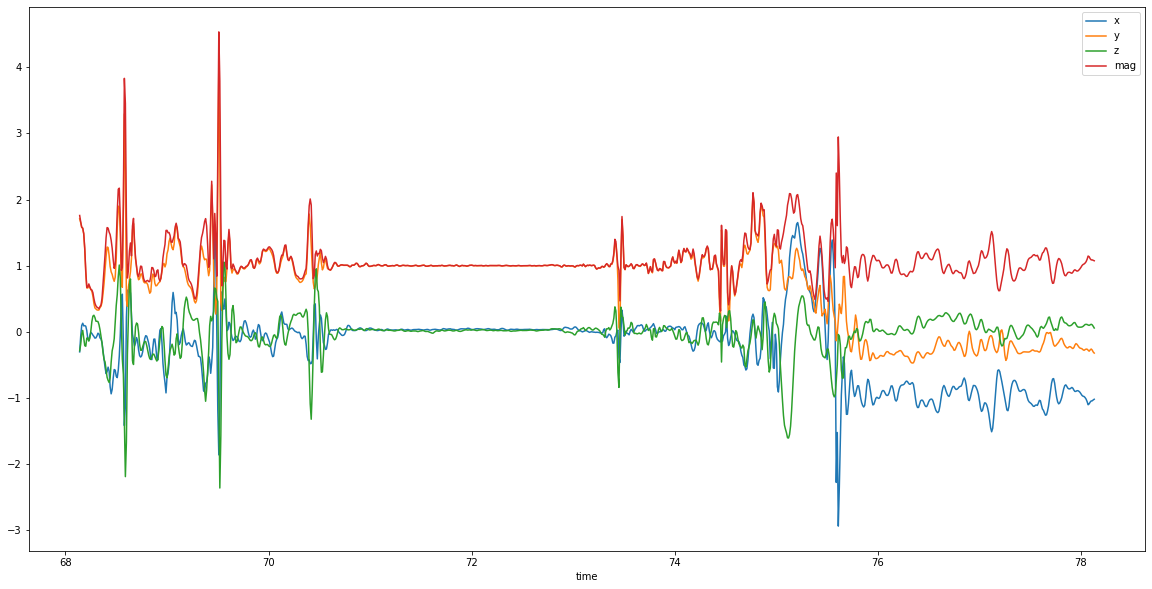

In [109]:
test.where(test["time"]>(test["time"].max()-10)).plot(x='time', figsize=(20, 10))

In [110]:
windows, labels, window_times = split_dataframe_to_windows(test, window_length=0.5, p1=10.4, p2=71.5)
for i, window in enumerate(windows):
    print(f"Okno {i + 1}:")
    print(len(window), labels[i], window_times[i])

Okno 1:
50 0 [0.0, 0.49]
Okno 2:
50 0 [0.5, 0.99]
Okno 3:
50 0 [1.0, 1.49]
Okno 4:
50 0 [1.5, 1.99]
Okno 5:
50 0 [2.0, 2.49]
Okno 6:
50 0 [2.5, 2.99]
Okno 7:
50 0 [3.0, 3.49]
Okno 8:
50 0 [3.5, 3.99]
Okno 9:
50 0 [4.0, 4.49]
Okno 10:
50 0 [4.5, 4.99]
Okno 11:
50 0 [5.0, 5.49]
Okno 12:
50 0 [5.5, 5.99]
Okno 13:
50 0 [6.0, 6.49]
Okno 14:
50 0 [6.5, 6.99]
Okno 15:
50 0 [7.0, 7.49]
Okno 16:
50 0 [7.5, 7.99]
Okno 17:
50 0 [8.0, 8.49]
Okno 18:
50 0 [8.5, 8.99]
Okno 19:
50 0 [9.0, 9.49]
Okno 20:
50 0 [9.5, 9.99]
Okno 21:
50 0 [10.0, 10.49]
Okno 22:
50 1 [10.5, 10.99]
Okno 23:
50 1 [11.0, 11.49]
Okno 24:
50 1 [11.5, 11.99]
Okno 25:
50 1 [12.0, 12.49]
Okno 26:
50 1 [12.5, 12.99]
Okno 27:
50 1 [13.0, 13.49]
Okno 28:
50 1 [13.5, 13.99]
Okno 29:
50 1 [14.0, 14.49]
Okno 30:
50 1 [14.5, 14.99]
Okno 31:
50 1 [15.0, 15.49]
Okno 32:
50 1 [15.5, 15.99]
Okno 33:
50 1 [16.0, 16.49]
Okno 34:
50 1 [16.5, 16.99]
Okno 35:
50 1 [17.0, 17.49]
Okno 36:
50 1 [17.5, 17.99]
Okno 37:
50 1 [18.0, 18.49]
Okno 38:
50 1

In [111]:
# reversing half of windows
windows1 = []
for i, window in enumerate(windows):
    if i <= len(windows)/2:
        windows1.append(window)
    else:
        windows1.append(window.iloc[::-1])

In [112]:
# # checking time needed for each function
# import time
# func = [(calculate_rise_fall_times, 'calculate_rise_fall_times'),
#         (calculate_rise_fall_times_optimized, 'calculate_rise_fall_times_optimized'),
#         (calculate_rise_fall_times_optimized_v3, 'calculate_rise_fall_times_optimized_v3')]
# results = []
# for fun, name in func:
#     func_to_test = fun
#     start_time = time.perf_counter()
#     a1, a2 = func_to_test(windows)
#     end_time = time.perf_counter()
#     results.append((a1,a2))
#     elapsed_time = end_time - start_time
#     print(f"Czas wykonywania funkcji{name}: {elapsed_time} sekund")

In [113]:
rise_times, fall_times = calculate_rise_fall_times_optimized(windows1)
# rise_times1, fall_times1 = duration_above_below_ma(windows1)

In [114]:
p0 = pd.DataFrame.from_dict(labels)
p1 = pd.DataFrame.from_dict(rise_times).reset_index().drop("r_mag", axis=1)
p2 = pd.DataFrame.from_dict(fall_times).reset_index().drop("f_mag", axis=1)
# p11 = pd.DataFrame.from_dict(rise_times1).reset_index().drop("a_mag", axis=1)
# p22 = pd.DataFrame.from_dict(fall_times1).reset_index().drop("b_mag", axis=1)
# X = p1.drop("index", axis=1)
X = p1.merge(p2).drop("index", axis=1)
# X = p1.merge(p2).merge(p11).merge(p22).drop("index", axis=1)
X.head()

,r_x,r_y,r_z,f_x,f_y,f_z
0,0.32,0.20,0.23,0.17,0.29,0.26
1,0.24,0.21,0.21,0.25,0.28,0.28
2,0.24,0.26,0.18,0.25,0.23,0.31
3,0.22,0.27,0.19,0.27,0.22,0.30
4,0.23,0.27,0.26,0.26,0.22,0.23


In [115]:
# function for setting train data
def get_indexes(window_times, safe_length_side, safe_length_middle):
    indexes = []
    middle_part = round(len(window_times)/2)
    middle_sec = (window_times[middle_part][0] + window_times[middle_part][1])/2
    for i, row in enumerate(window_times):
        if row[1] <= safe_length_side:
            indexes.append(i)
        elif row[0] >= (window_times[-1][0] - safe_length_side):
            indexes.append(i)
        elif (row[0] >= (middle_sec - safe_length_middle)) and (row[1] <= (middle_sec + safe_length_middle)):
            indexes.append(i)
    return indexes

In [116]:
train_idx = get_indexes(window_times, 3.0, 3.0)
print(train_idx)
print(f"Amount of train data: {len(train_idx)}")

[0, 1, 2, 3, 4, 5, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 149, 150, 151, 152, 153, 154, 155]
Amount of train data: 24


In [156]:
# test
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
# clf = LinearSVC()
# clf = RandomForestClassifier(class_weight={0:0.9, 1:0.1})
# clf = AdaBoostClassifier(n_estimators=100)
clf = SVC(C=0.000001, kernel='poly', degree=5, probability=True, class_weight={0:0.9, 1:0.1})
clf.fit(X.iloc[train_idx], [labels[i] for i in train_idx])
y_pred = clf.predict(X)
print(accuracy_score(labels, y_pred))
print(classification_report(labels, y_pred))

0.3269230769230769
              precision    recall  f1-score   support

           0       0.24      0.97      0.39        34
           1       0.95      0.15      0.26       122

    accuracy                           0.33       156
   macro avg       0.59      0.56      0.32       156
weighted avg       0.79      0.33      0.28       156



In [157]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [158]:
def modify_list(input_list):
    first_one = input_list.index(1)
    last_one = len(input_list) - 1 - input_list[::-1].index(1)
    modified_list = input_list.copy()
    for i in range(first_one, last_one + 1):
        modified_list[i] = 1
    return modified_list
y_pred1 = modify_list(y_pred.tolist())
print(classification_report(labels, y_pred1))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        34
           1       0.94      0.94      0.94       122

    accuracy                           0.91       156
   macro avg       0.87      0.87      0.87       156
weighted avg       0.91      0.91      0.91       156



In [55]:
def modify_list2(input_list):
    first_one = input_list.index(1)
    last_one = len(input_list) - 1 - input_list[::-1].index(1)
    modified_list = input_list.copy()
    modified_list[first_one] = 0
    modified_list[last_one] = 0
    return modified_list

In [56]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [57]:
print(y_pred1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
print(modify_list2(y_pred1))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [160]:
foldername = "third-run"
input_data = pd.read_csv('startend_points.csv', sep=';', decimal=",")
# input_data = input_data.iloc[:2]
results = pd.DataFrame()
for idx, row in input_data.iterrows():


    print(f"filename: {row['filename']} p1: {row['p1']} p2: {row['p2']}")
    temp = pd.read_csv(os.path.join(foldername, row['filename']))
    activity = temp['activity'].unique()[0]
    temp = temp[['time','x','y','z','mag']]
    temp['time'] = (temp['time'] - temp['time'].iloc[0])/1000000000

    windows, labels, window_times = split_dataframe_to_windows(temp, window_length=0.5, p1=row['p1'], p2=row['p2'])

    windows1 = []
    for i, window in enumerate(windows):
        if i <= len(windows)/2:
            windows1.append(window)
        else:
            windows1.append(window.iloc[::-1])
    rise_times, fall_times = calculate_rise_fall_times_optimized(windows1)
    # rise_times1, fall_times1 = duration_above_below_ma(windows1)

    p1 = pd.DataFrame.from_dict(rise_times).reset_index().drop("r_mag", axis=1)
    p2 = pd.DataFrame.from_dict(fall_times).reset_index().drop("f_mag", axis=1)
    # p11 = pd.DataFrame.from_dict(rise_times1).reset_index().drop("a_mag", axis=1)
    # p22 = pd.DataFrame.from_dict(fall_times1).reset_index().drop("b_mag", axis=1)
    X = p1.merge(p2).drop("index", axis=1)
    # X = p1.merge(p2).merge(p11).merge(p22).drop("index", axis=1)

    train_idx = get_indexes(window_times, 3.0, 3.0)
    # clf = RandomForestClassifier(class_weight={0:0.9, 1:0.1})
    clf = SVC(C=0.00001, kernel='poly', degree=5, probability=False, class_weight={0:0.9, 1:0.1})
    # clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(X.iloc[train_idx], [labels[i] for i in train_idx])
    y_pred = clf.predict(X)
    raw_results = precision_recall_fscore_support(labels, y_pred)
    y_pred1 = modify_list(y_pred.tolist())
    mod_results = precision_recall_fscore_support(labels, y_pred1)
    y_pred2 = modify_list2(y_pred1)
    mod2_results = precision_recall_fscore_support(labels, y_pred2)
    row_result_dict = {'name': filename, 'activity': activity,
                  'raw_p0': raw_results[0][0], 'raw_r0': raw_results[0][1], 'raw_p1': raw_results[1][0], 'raw_r1': raw_results[1][1],
                  'mod1_p0': mod_results[0][0], 'mod1_r0': mod_results[0][1], 'mod1_p1': mod_results[1][0], 'mod1_r1': mod_results[1][1],
                  'mod2_p0': mod2_results[0][0], 'mod2_r0': mod2_results[0][1], 'mod2_p1': mod2_results[1][0], 'mod2_r1': mod2_results[1][1],
                  }
    temp_df = pd.DataFrame(row_result_dict, index=[0])
    results = pd.concat([results,temp_df]).reset_index(drop=True)
results.head()
results.to_csv('results_r_nomag_d5.csv', index=False)

filename: InterpolationAccelerometerKubaDownstairs3Apple.csv p1: 3.4 p2: 75.0
filename: InterpolationAccelerometerKubaDownstairs2Apple.csv p1: 4.0 p2: 69.0
filename: InterpolationAccelerometerKubaSquatsApple.csv p1: 3.8 p2: 124.0
filename: InterpolationAccelerometerKubaSittingApple.csv p1: 4.8 p2: 332.0
filename: InterpolationAccelerometerKubaSquats2Apple.csv p1: 7.6 p2: 132.3
filename: InterpolationAccelerometerKubaSquats3Apple.csv p1: 3.9 p2: 126.1
filename: InterpolationAccelerometerKubaStanding2Apple.csv p1: 3.2 p2: 127.6
filename: InterpolationAccelerometerKubaStanding3Apple.csv p1: 5.0 p2: 125.0
filename: InterpolationAccelerometerKubaWalking2Apple.csv p1: 4.6 p2: 579.6
filename: InterpolationAccelerometerKubaDownstairsApple.csv p1: 10.4 p2: 71.5
filename: InterpolationAccelerometerKubaSitting2Apple.csv p1: 4.7 p2: 295.3
filename: InterpolationAccelerometerKubaUpstairsApple.csv p1: 3.3 p2: 67.0
filename: InterpolationAccelerometerKubaWalkingApple.csv p1: 3.5 p2: 340.2
filename: I

In [363]:
results.head(19)

,name,activity,raw_p0,raw_r0,raw_p1,raw_r1,mod1_p0,mod1_r0,mod1_p1,mod1_r1,mod2_p0,mod2_r0,mod2_p1,mod2_r1
0,InterpolationAccelerometerKubaDownstairsApple.csv,downstairs,0.196970,1.000000,1.000000,0.629371,1.000000,1.000000,1.000000,1.000000,0.866667,1.000000,1.000000,0.986014
1,InterpolationAccelerometerKubaDownstairsApple.csv,downstairs,0.260000,0.989362,0.928571,0.715385,1.000000,0.984848,0.857143,1.000000,0.928571,0.992308,0.928571,0.992308
2,InterpolationAccelerometerKubaDownstairsApple.csv,squats,0.104478,0.991736,0.933333,0.500000,1.000000,0.991736,0.866667,1.000000,0.933333,0.995833,0.933333,0.995833
3,InterpolationAccelerometerKubaDownstairsApple.csv,sitting,0.066351,0.989177,0.736842,0.698777,1.000000,0.992413,0.736842,1.000000,1.000000,0.995434,0.842105,1.000000
4,InterpolationAccelerometerKubaDownstairsApple.csv,squats,0.148936,0.958333,0.437500,0.838057,1.000000,0.961089,0.375000,1.000000,0.875000,0.964706,0.437500,0.995951
5,InterpolationAccelerometerKubaDownstairsApple.csv,squats,0.193878,0.988024,0.904762,0.676230,1.000000,0.991870,0.904762,1.000000,0.952381,0.995902,0.952381,0.995902
6,InterpolationAccelerometerKubaDownstairsApple.csv,standing,0.094675,0.989583,0.941176,0.383065,0.888889,0.995951,0.941176,0.991935,0.850000,1.000000,1.000000,0.987903
7,InterpolationAccelerometerKubaDownstairsApple.csv,standing,0.153846,0.962025,0.727273,0.633333,1.000000,0.963855,0.590909,1.000000,1.000000,0.971660,0.681818,1.000000
8,InterpolationAccelerometerKubaDownstairsApple.csv,walking,0.031250,0.998540,0.937500,0.595300,1.000000,0.999130,0.937500,1.000000,0.941176,1.000000,1.000000,0.999130
9,InterpolationAccelerometerKubaDownstairsApple.csv,downstairs,0.406250,0.913043,0.764706,0.688525,1.000000,0.859155,0.411765,1.000000,1.000000,0.871429,0.470588,1.000000


In [54]:
results.head(19)

,name,activity,raw_p0,raw_r0,raw_p1,raw_r1,mod1_p0,mod1_r0,mod1_p1,mod1_r1,mod2_p0,mod2_r0,mod2_p1,mod2_r1
0,InterpolationAccelerometerKubaUpstairs2Apple.csv,downstairs,0.307692,0.991453,0.923077,0.811189,1.000000,0.993056,0.923077,1.000000,0.928571,1.000000,1.000000,0.993007
1,InterpolationAccelerometerKubaUpstairs2Apple.csv,downstairs,0.225806,1.000000,1.000000,0.630769,0.933333,1.000000,1.000000,0.992308,0.823529,1.000000,1.000000,0.976923
2,InterpolationAccelerometerKubaUpstairs2Apple.csv,squats,0.100719,0.991379,0.933333,0.479167,1.000000,0.991736,0.866667,1.000000,0.933333,0.995833,0.933333,0.995833
3,InterpolationAccelerometerKubaUpstairs2Apple.csv,sitting,0.039627,0.991803,0.894737,0.370031,1.000000,0.990909,0.684211,1.000000,1.000000,0.993921,0.789474,1.000000
4,InterpolationAccelerometerKubaUpstairs2Apple.csv,squats,0.068627,0.944099,0.437500,0.615385,0.777778,0.964567,0.437500,0.991903,0.727273,0.968254,0.500000,0.987854
5,InterpolationAccelerometerKubaUpstairs2Apple.csv,squats,0.145985,0.992188,0.952381,0.520492,1.000000,0.991870,0.904762,1.000000,0.952381,0.995902,0.952381,0.995902
6,InterpolationAccelerometerKubaUpstairs2Apple.csv,standing,0.083770,0.986486,0.941176,0.294355,0.750000,0.991837,0.882353,0.979839,0.727273,0.995885,0.941176,0.975806
7,InterpolationAccelerometerKubaUpstairs2Apple.csv,standing,0.120301,0.953488,0.727273,0.512500,1.000000,0.971660,0.681818,1.000000,1.000000,0.979592,0.772727,1.000000
8,InterpolationAccelerometerKubaUpstairs2Apple.csv,walking,0.030928,0.998529,0.937500,0.590949,1.000000,0.999130,0.937500,1.000000,0.941176,1.000000,1.000000,0.999130
9,InterpolationAccelerometerKubaUpstairs2Apple.csv,downstairs,0.312500,0.933333,0.882353,0.459016,1.000000,0.890511,0.558824,1.000000,0.952381,0.896296,0.588235,0.991803


In [367]:
rev_data_nomag_ada.drop(9).mean(axis=0)

C:\Users\gad\AppData\Local\Temp/ipykernel_6860/3123434673.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rev_data_nomag_ada.drop(9).mean(axis=0)


raw_p0     0.121466
raw_r0     0.982180
raw_p1     0.840276
raw_r1     0.574264
mod1_p0    0.967484
mod1_r0    0.985640
mod1_p1    0.778013
mod1_r1    0.997889
mod2_p0    0.921062
mod2_r0    0.990134
mod2_p1    0.848955
mod2_r1    0.994299
dtype: float64

In [265]:
rev_data_nomag.drop(9).mean(axis=0)

C:\Users\gad\AppData\Local\Temp/ipykernel_6860/633155545.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rev_data_nomag.drop(9).mean(axis=0)


raw_p0     0.089014
raw_r0     0.983496
raw_p1     0.908825
raw_r1     0.367424
mod1_p0    0.912537
mod1_r0    0.990991
mod1_p1    0.863727
mod1_r1    0.993443
mod2_p0    0.861154
mod2_r0    0.994272
mod2_p1    0.911208
mod2_r1    0.988570
dtype: float64

In [161]:
rev_data = pd.read_csv('results_reversed.csv')
notrev_data = pd.read_csv('results_notreversed.csv')
rev_data_nomag = pd.read_csv('results_reversed_nomag.csv')
data_nomag = pd.read_csv('results_nomag.csv')
rev_data_nomag_ada = pd.read_csv('results_r_nomag_ada.csv')
data_nomag_ada = pd.read_csv('results_nomag_ada.csv')
rev_data_nomag_c0d1 = pd.read_csv('results_r_nomag_c0d1.csv')
rev_data_nomag_c0d05 = pd.read_csv('results_r_nomag_c0d05.csv')
rev_data_nomag_c5 = pd.read_csv('results_r_nomag_d5.csv')
df_result = pd.concat([rev_data.mean(axis=0), notrev_data.mean(axis=0), rev_data_nomag.mean(axis=0), data_nomag.mean(axis=0), rev_data_nomag_ada.mean(axis=0), data_nomag_ada.mean(axis=0), rev_data_nomag_c0d1.mean(axis=0),  rev_data_nomag_c0d05.mean(axis=0), rev_data_nomag_c5.mean(axis=0)], axis=1)
df_result.columns = ['normal_r', 'normal', 'normal_r_nomag', 'normal_nomag', 'normal_r_nomag_ada', 'normal_nomag_ada', 'normal_r_nomag_c0d1', 'normal_r_nomag_c0d05', 'normal_r_nomag_d5']
df_result.head(len(df_result))

C:\Users\gad\AppData\Local\Temp/ipykernel_28624/1755374979.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_result = pd.concat([rev_data.mean(axis=0), notrev_data.mean(axis=0), rev_data_nomag.mean(axis=0), data_nomag.mean(axis=0), rev_data_nomag_ada.mean(axis=0), data_nomag_ada.mean(axis=0), rev_data_nomag_c0d1.mean(axis=0),  rev_data_nomag_c0d05.mean(axis=0), rev_data_nomag_c5.mean(axis=0)], axis=1)


,normal_r,normal,normal_r_nomag,normal_nomag,normal_r_nomag_ada,normal_nomag_ada,normal_r_nomag_c0d1,normal_r_nomag_c0d05,normal_r_nomag_d5
raw_p0,0.121358,0.127569,0.102795,0.110507,0.137287,0.139015,0.088489,0.082257,0.083208
raw_r0,0.981184,0.982804,0.981096,0.978786,0.978339,0.979202,0.962091,0.955505,0.972500
raw_p1,0.879364,0.896445,0.907354,0.882446,0.836078,0.856087,0.963252,0.973961,0.951011
raw_r1,0.482859,0.540050,0.375700,0.460028,0.580612,0.601222,0.223077,0.161224,0.193833
mod1_p0,0.939783,0.936971,0.917396,0.928169,0.969290,0.967435,0.793512,0.673767,0.752152
mod1_r0,0.984076,0.984603,0.984697,0.983385,0.978613,0.981412,0.991255,0.992371,0.990455
mod1_p1,0.818476,0.837794,0.843520,0.800361,0.757666,0.795482,0.911206,0.931835,0.900206
mod1_r1,0.995994,0.995756,0.993808,0.996658,0.998006,0.997877,0.976899,0.891682,0.944651
mod2_p0,0.888699,0.881841,0.868868,0.888199,0.925447,0.919165,0.744046,0.633033,0.713700
mod2_r0,0.987873,0.988376,0.988508,0.988348,0.983539,0.986074,0.993503,0.938766,0.992963
